<a href="https://colab.research.google.com/github/praymesh/VLM-SEGMENTATION/blob/main/Visual_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from transformers import AutoProcessor, AutoModel
from PIL import Image
import numpy as np


Comparision of Sg1 and Sg2 : https://huggingface.co/spaces/google/zero-shot-sg1-sg2\

SigLIP 2 is pre-trained on the WebLI dataset (Chen et al., 2023).
Model Used as of Now : google/siglip2-base-patch16-224-jax : https://huggingface.co/google/siglip2-base-patch16-224-jax

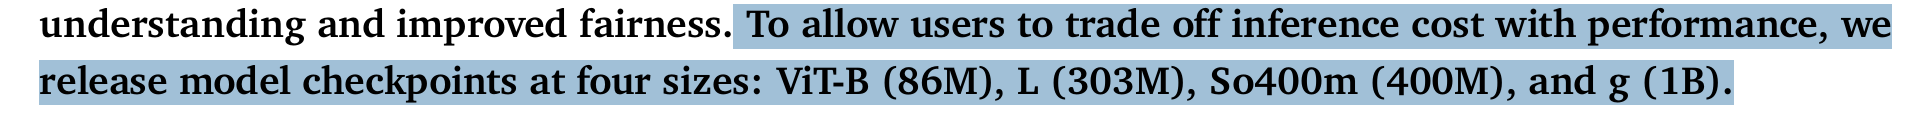

In [ ]:
# huggngface auth

from huggingface_hub import notebook_login
notebook_login()

In [1]:
# Initialize SIGLIP 2, We Will use the Base Model
model_name = "google/siglip2-base-patch16-224-jax"
processor = AutoProcessor.from_pretrained(model_name)
siglip2 = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:

class SIGLIPSeg(torch.nn.Module):
    def __init__(self, siglip_model, hidden_size=1024):
        super().__init__()
        self.vision_model = siglip_model.vision_model
        self.text_model = siglip_model.text_model
        self.mask_decoder = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size, 256, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=4, mode='bilinear'),
            torch.nn.Conv2d(256, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 64, 3, padding=1),
            torch.nn.Upsample(scale_factor=4, mode='bilinear')
        )

    def forward(self, pixel_values, text_tokens):
        # Extract image features
        vision_output = self.vision_model(pixel_values=pixel_values)
        image_embeds = vision_output.last_hidden_state[:, 1:]  # Remove CLS token

        # Extract text features
        text_output = self.text_model(input_ids=text_tokens)
        text_embeds = text_output.last_hidden_state[:, 0]  # CLS token

        # Reshape to spatial dimensions
        h = w = int(image_embeds.shape[1]**0.5)
        image_embeds = image_embeds.permute(0, 2, 1).view(-1, 1024, h, w)

        # Fuse features (element-wise multiplication)
        fused = image_embeds * text_embeds.unsqueeze(-1).unsqueeze(-1)

        # Generate masks
        masks = self.mask_decoder(fused)
        return masks